# Foreground Extinction Correction + Color-Magnitude Diagrams

We introduce the foreground-corrected color-magnitude diagrams used in the analysis of our stellar population. The photometric data presented here comes from the following sources. <b>NUV Photometry:</b> Derived from a [composition](https://github.com/lfulmer/star-formation-smc-wing/blob/master/images/ngc602_crop.fits) of archival images from the Galaxy Evolution Explorer (GALEX), from which we extracted individual stellar photometry using IRAF Daophot. We chose to manually extract NUV photometry - rather than use the archival NUV catalog provided by GALEX - due to its insufficient sampling. <b>B + V Photometry:</b> Archival optical photometric measurements taken with the ESO Danish 1.54m Telescope ([Braun 2001](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=II/232/smc1)).

We seek to estimate an SMC foreground extinction correction for our stellar sample. We demonstrate a photometric comparison between stars among four regions, both within and on the edge of the HI supershell DEM 167. Following an analysis of the observed foreground extinction, we apply the corrections for each region to the stellar photometry. The following image illustrates the regions in question, where Region II indicates stars "within" the shell, and Regions I, III, and IV indicate those "on the edge" of the shell.  <br>
<img src="images/Shell_Environment_Regions.png" width=520px>

## Import modules

In [1]:
# Standard
import numpy as np
import matplotlib.pyplot as plt

# Auxillary
import smc
from scipy import stats

%config InlineBackend.figure_format = "retina"
%matplotlib inline

## Foreground-uncorrected data

In [2]:
# Photometry
phot_file = np.genfromtxt('../data/foreground_uncorrected_photometry', dtype = None, names = True)

# Photometry + spectra
spec_file = np.genfromtxt('../data/foreground_uncorrected_photometry_and_stellar_parameters', \
                          dtype = None, names = True)

# Gaia proper motion >= 4 mas/year
high_proper_motion_coordinates = np.genfromtxt('../data/high_proper_motion_coordinates_phot', \
                                               dtype = None, names = True)

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """


## Define function for determining extinction correction

In [3]:
def extinction_correction(band, x, y, mainx, mainy, eb_v, spectral_eb_v, \
                          color, title, label, fit_intercept, fit_slope):
    
    a_b = 3.85 * eb_v
    a_v = 2.93 * eb_v
    a_nuv = 8.08 * eb_v
    
    if band == 'B':
        x, y = x + a_b - a_v, y + a_v
        mainx, mainy = mainx + a_b - a_v, mainy + a_v
    elif band == 'NUV':
        x, y = x + a_nuv - a_v, y + a_nuv
        mainx, mainy = mainx + a_nuv - a_v, mainy + a_nuv
    
    ridge_centroidsx, ridge_centroidsy = smc.find_ridge_line(mainx, mainy, 6)
    fit, intercept, slope = smc.ridge_fit(x, y, mainx, mainy, ridge_centroidsx, ridge_centroidsy)
    # print(intercept, slope)
    
    # These values come from the intercept + slope found in smc.ridge_fit
    fit_II = fit_intercept + x * fit_slope
    
    plt.plot(mainx, fit, color='k', linewidth=2, \
             label="E(B-V) = "+str(np.round(np.abs(eb_v), 3))+" main seq. fit", zorder=2)

    plt.plot(x, fit_II, color='dodgerblue', linewidth=2, \
             label="Region II main sequence fit", alpha = 0.6, zorder=1)
    
    plt.scatter(x, y, color=color, s=10, marker="o", alpha=0.6, zorder=3)
    plt.scatter(mainx, mainy, color=color, s=15, marker="o", zorder=4)
    
    if band == 'B':
        smc.plt_b(title, True)
    elif band == 'NUV':
        smc.plt_nuv(title, True)

## Define stellar population: photometry

In [4]:
# Photometry
# mag_correction = -18.7
# galactic_correction_nuv = 0.42, galactic_correction_v = 0.16

nuv = smc.organize_data(phot_file, 'NUV', leader = True, mag_and_galactic_correction = -19.12, \
                        catalog_correction = 0.6)
nuv_v = smc.organize_data(phot_file, 'NUV_V', leader = False, label = nuv, \
                          mag_and_galactic_correction = -0.26, catalog_correction = 0.6)
b_v = smc.organize_data(phot_file, 'B_V', leader = False, label = nuv, mag_and_galactic_correction = 0.16)
v = smc.organize_data(phot_file, 'V', leader = False, label = nuv, mag_and_galactic_correction = -18.86)
id_number = smc.organize_data(phot_file, 'ID', leader = False, label = nuv)
ra = smc.organize_data(phot_file, 'RA', leader = False, label = nuv)
dec = smc.organize_data(phot_file, 'DEC', leader = False, label = nuv)

# Remove stars with abnormally high proper motions
# The file "foreground_corrected_photometry_with_high_proper_motions" was created without this correction
within_smc = smc.remove_high_proper_motion(ra.data, dec.data, high_proper_motion_coordinates['ra'], \
                          high_proper_motion_coordinates['dec'])

# To remake the file "foreground_corrected_photometry_with_high_proper_motions", use the following:
# within_smc = [True] * len(nuv.data)

id_number, ra, dec, nuv_v, nuv, b_v, v = \
id_number.data[within_smc], ra.data[within_smc], dec.data[within_smc], \
nuv_v.data[within_smc], nuv.data[within_smc], b_v.data[within_smc], v.data[within_smc]

# Summary 
print("There are", len(nuv), "field stars in our photometric sample")

There are 1073 field stars in our photometric sample


## Define stellar population: photometry + spectroscopy

In [5]:
# Photometry + Spectroscopy
s_nuv = smc.organize_data(spec_file, 'NUV', leader = True, mag_and_galactic_correction = -19.12, \
                          catalog_correction = 0.6)
s_id = smc.organize_data(spec_file, 'ID')
s_ra = smc.organize_data(spec_file, 'RA')
s_dec = smc.organize_data(spec_file, 'DEC')
s_nuv_v = smc.organize_data(spec_file, 'NUV_V', leader = False, label = s_nuv, \
                            mag_and_galactic_correction = -0.26, catalog_correction = 0.6)
s_b_v = smc.organize_data(spec_file, 'B_V', leader = False, label = s_nuv, mag_and_galactic_correction = 0.16)
s_v = smc.organize_data(spec_file, 'V', leader = False, label = s_nuv, mag_and_galactic_correction = -18.86)
s_type = smc.organize_data(spec_file, 'SpectralType')
s_EB_V = smc.organize_data(spec_file, 'EB_V')

# Remove stars with abnormally high proper motions
within_smc = smc.remove_high_proper_motion(s_ra.data, s_dec.data, high_proper_motion_coordinates['ra'], \
                          high_proper_motion_coordinates['dec'])

s_id, s_ra, s_dec, s_nuv_v, s_nuv, s_b_v, s_v, s_type, s_EB_V = \
s_id.data[within_smc], s_ra.data[within_smc], s_dec.data[within_smc], \
s_nuv_v.data[within_smc], s_nuv.data[within_smc], s_b_v.data[within_smc], s_v.data[within_smc], \
s_type.data[within_smc], s_EB_V.data[within_smc]

# Summary 
print("There are", len(s_nuv), "field stars in our photometric + spectroscopic sample")

There are 110 field stars in our photometric + spectroscopic sample


## Define regions

In [6]:
# Photometry
photometric_sample = id_number, ra, dec, nuv_v, nuv, b_v, v

# band, sample, bounds
Region_I, Region_II, Region_III, Region_IV = smc.boundary_conditions(photometric_sample)
I = smc.assign_region_boundaries(photometric_sample, Region_I)
II = smc.assign_region_boundaries(photometric_sample, Region_II)
III = smc.assign_region_boundaries(photometric_sample, Region_III)
IV = smc.assign_region_boundaries(photometric_sample, Region_IV)

# Summary 
print("We have stellar photometry for {} stars: \n{} stars in Region I, {} stars in Region II, {} stars in Region III,\
and {} stars in Region IV".format(len(v), len(I.v), len(II.v), len(III.v), len(IV.v)))

We have stellar photometry for 1073 stars: 
153 stars in Region I, 355 stars in Region II, 194 stars in Region III,and 371 stars in Region IV


In [7]:
# Photometry + Spectra
spectroscopic_sample = s_id, s_ra, s_dec, s_nuv_v, s_nuv, s_b_v, s_v, s_type, s_EB_V

# band, sample, bounds
Region_I, Region_II, Region_III, Region_IV = smc.boundary_conditions(spectroscopic_sample)
s_I = smc.assign_region_boundaries(spectroscopic_sample, Region_I)
s_II = smc.assign_region_boundaries(spectroscopic_sample, Region_II)
s_III = smc.assign_region_boundaries(spectroscopic_sample, Region_III)
s_IV = smc.assign_region_boundaries(spectroscopic_sample, Region_IV)


# Summary 
print("We have photometry + spectra for {} stars: \n{} stars in Region I, {} stars in Region II, {} stars in Region III,\
and {} stars in Region IV".format(len(s_v), len(s_I.v), len(s_II.v), len(s_III.v), len(s_IV.v)))

We have photometry + spectra for 110 stars: 
0 stars in Region I, 30 stars in Region II, 28 stars in Region III,and 52 stars in Region IV


## A little reorganization

In [8]:
# Define parameter lists
colors = ['maroon', 'firebrick', 'indianred', 'crimson']
labels = ['Region I', 'Region II', 'Region III', 'Region IV']

EB_V = np.array([-0.04, 0.000, 0.000, -0.08])
spectral_EB_V = (np.mean(s_I.EB_V), np.mean(s_II.EB_V), np.mean(s_III.EB_V), np.mean(s_IV.EB_V))

A_B = EB_V * 3.85
A_V = EB_V * 2.93
A_NUV = EB_V * 8.08

RA = [I.ra, II.ra, III.ra, IV.ra]
DEC = [I.dec, II.dec, III.dec, IV.dec]

B_V = [I.b_v, II.b_v, III.b_v, IV.b_v]
V = [I.v, II.v, III.v, IV.v]

B_V_MAIN = [I.b_v_main, II.b_v_main, III.b_v_main, IV.b_v_main]
V_MAIN = [I.v_main, II.v_main, III.v_main, IV.v_main]

NUV_V = [I.nuv_v, II.nuv_v, III.nuv_v, IV.nuv_v]
NUV = [I.nuv, II.nuv, III.nuv, IV.nuv]

NUV_V_MAIN = [I.nuv_v_main, II.nuv_v_main, III.nuv_v_main, IV.nuv_v_main]
NUV_MAIN = [I.nuv_main, II.nuv_main, III.nuv_main, IV.nuv_main]

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Foreground extinction analysis

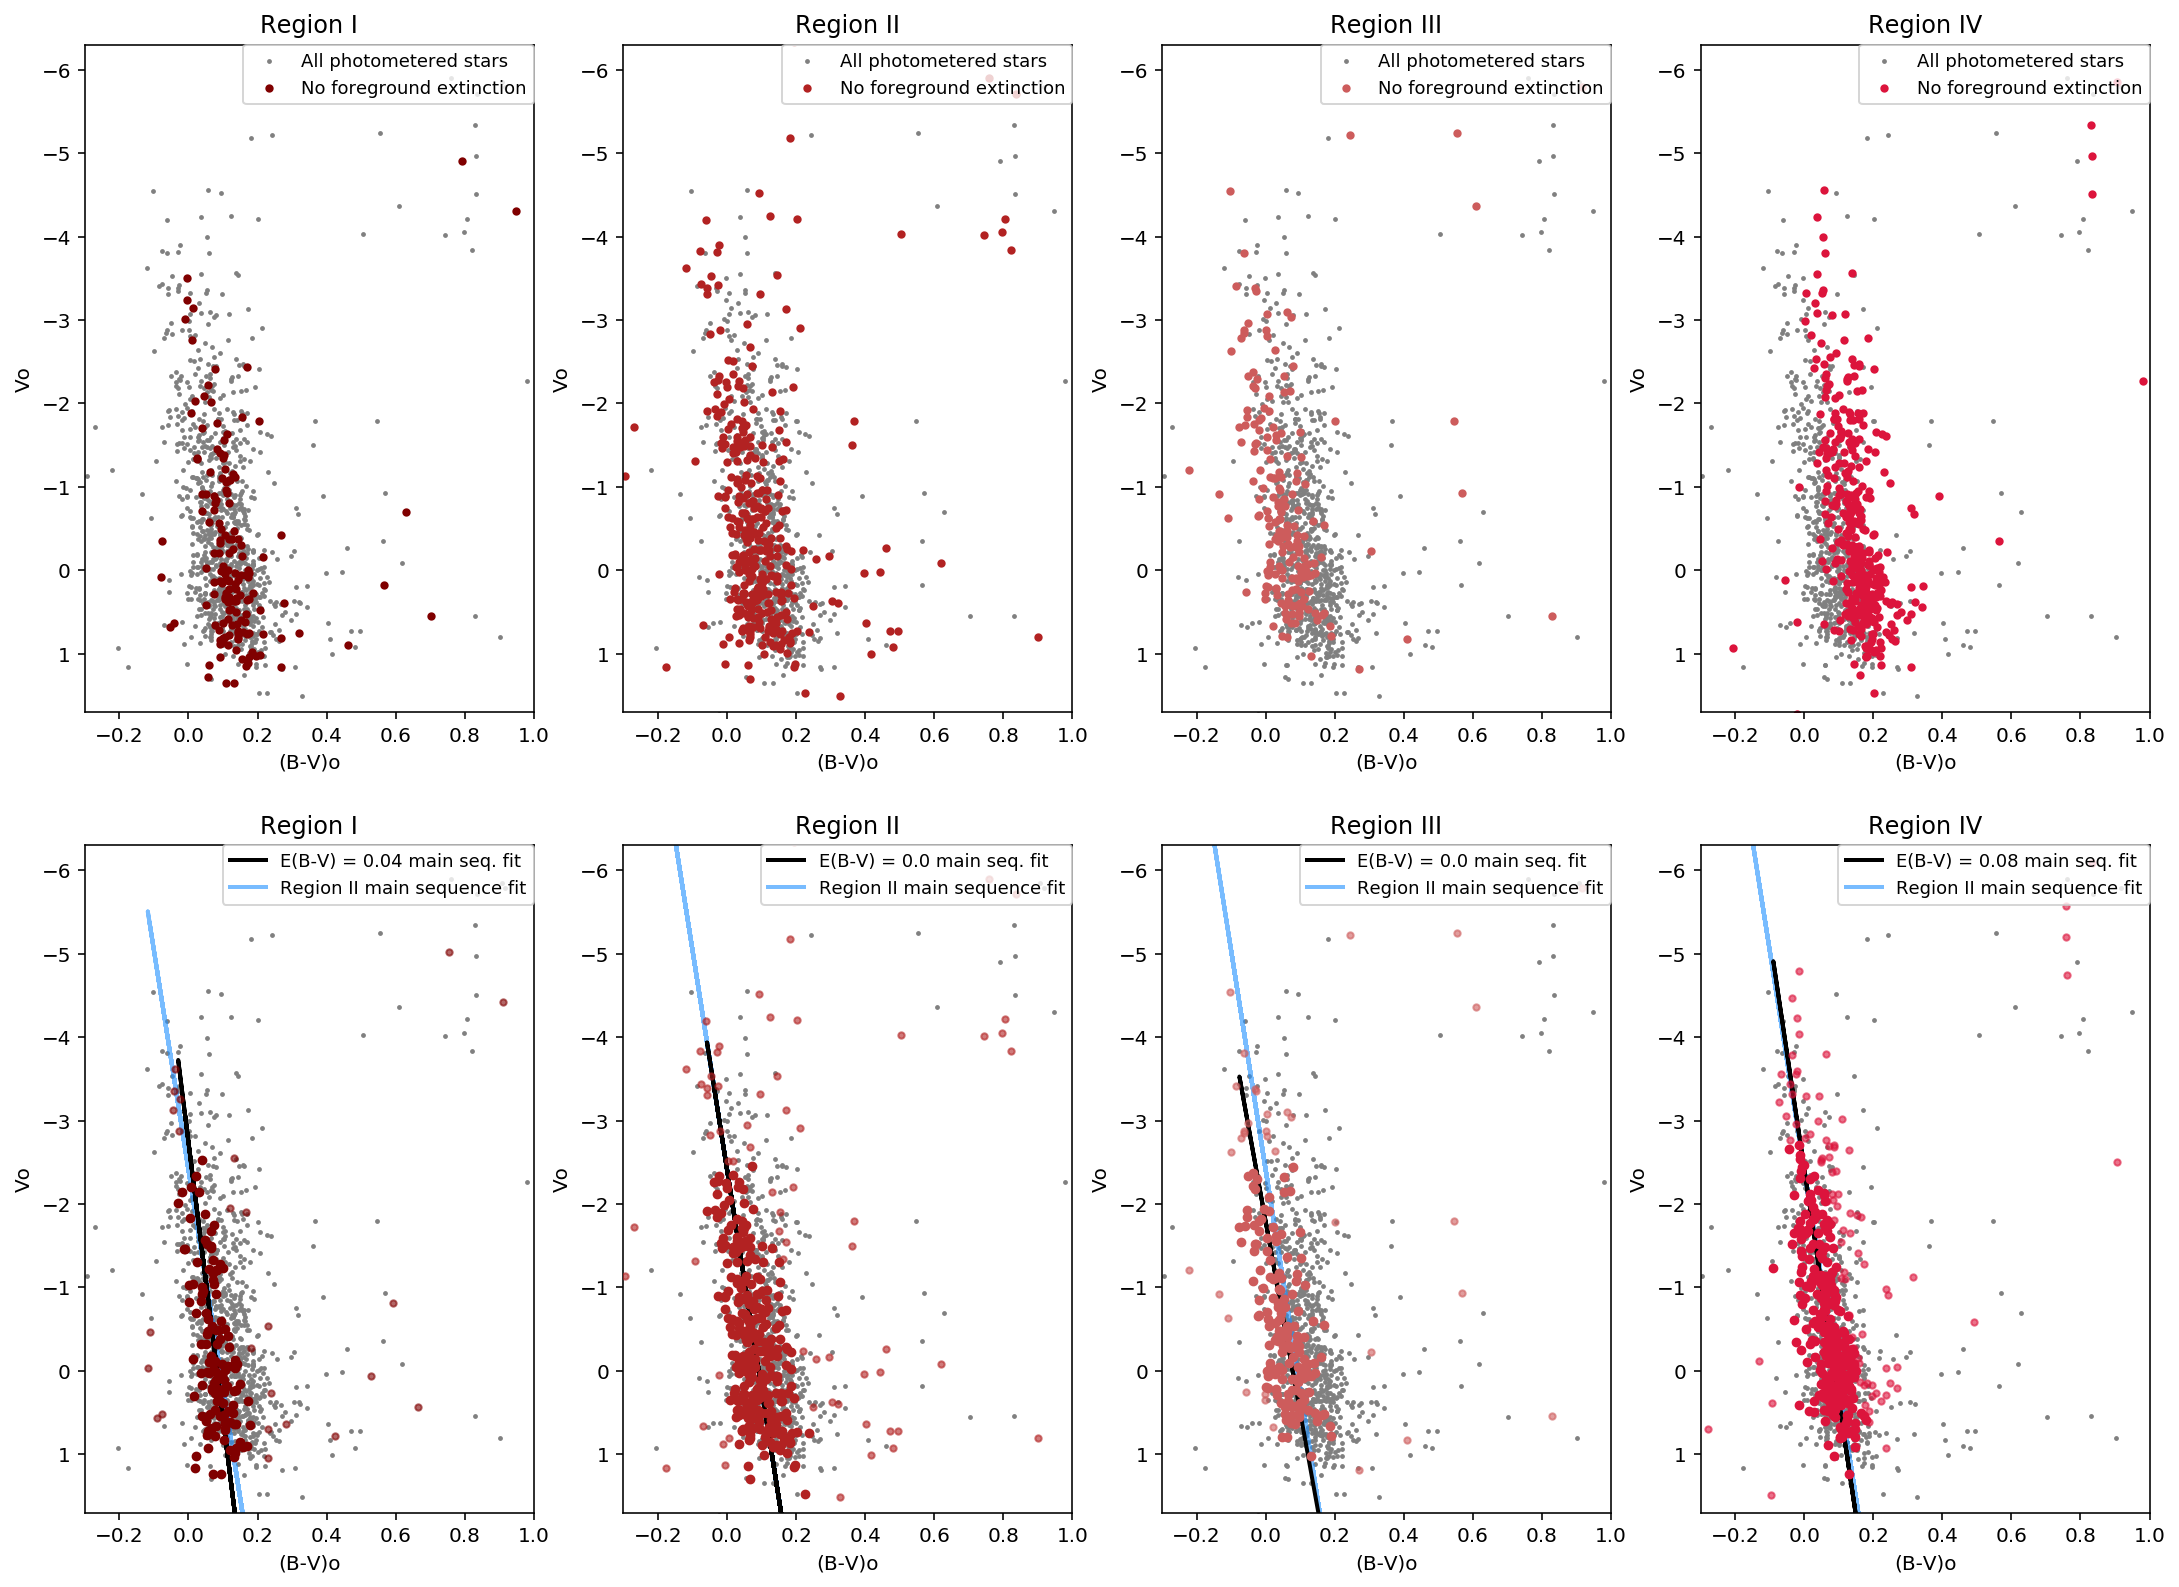

In [9]:
# Plot
plt.figure(figsize=(18.5, 13.5))
a,b = 2,4

# No foreground extinction
for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+1)
    smc.plot_field(b_v, v, True)
    smc.plot_region('b', B_V[i], V[i], colors[i], labels[i], 'No foreground extinction', True)
    
# Foreground extinction
for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+5)
    smc.plot_field(B_V[(i+1) % 4], V[(i+1) % 4], False)
    smc.plot_field(B_V[(i+2) % 4], V[(i+2) % 4], False)
    smc.plot_field(B_V[(i+3) % 4], V[(i+3) % 4], False)
    
    extinction_correction('B', B_V[i], V[i], B_V_MAIN[i], V_MAIN[i], EB_V[i], \
                            spectral_EB_V[i], colors[i], labels[i], labels[i], \
                          -2.4112763316065164, 26.288656137565248)

plt.savefig("images/Shell_Environment_Photometric_Comparison_B.jpg")
plt.show()

## Foreground extinction application

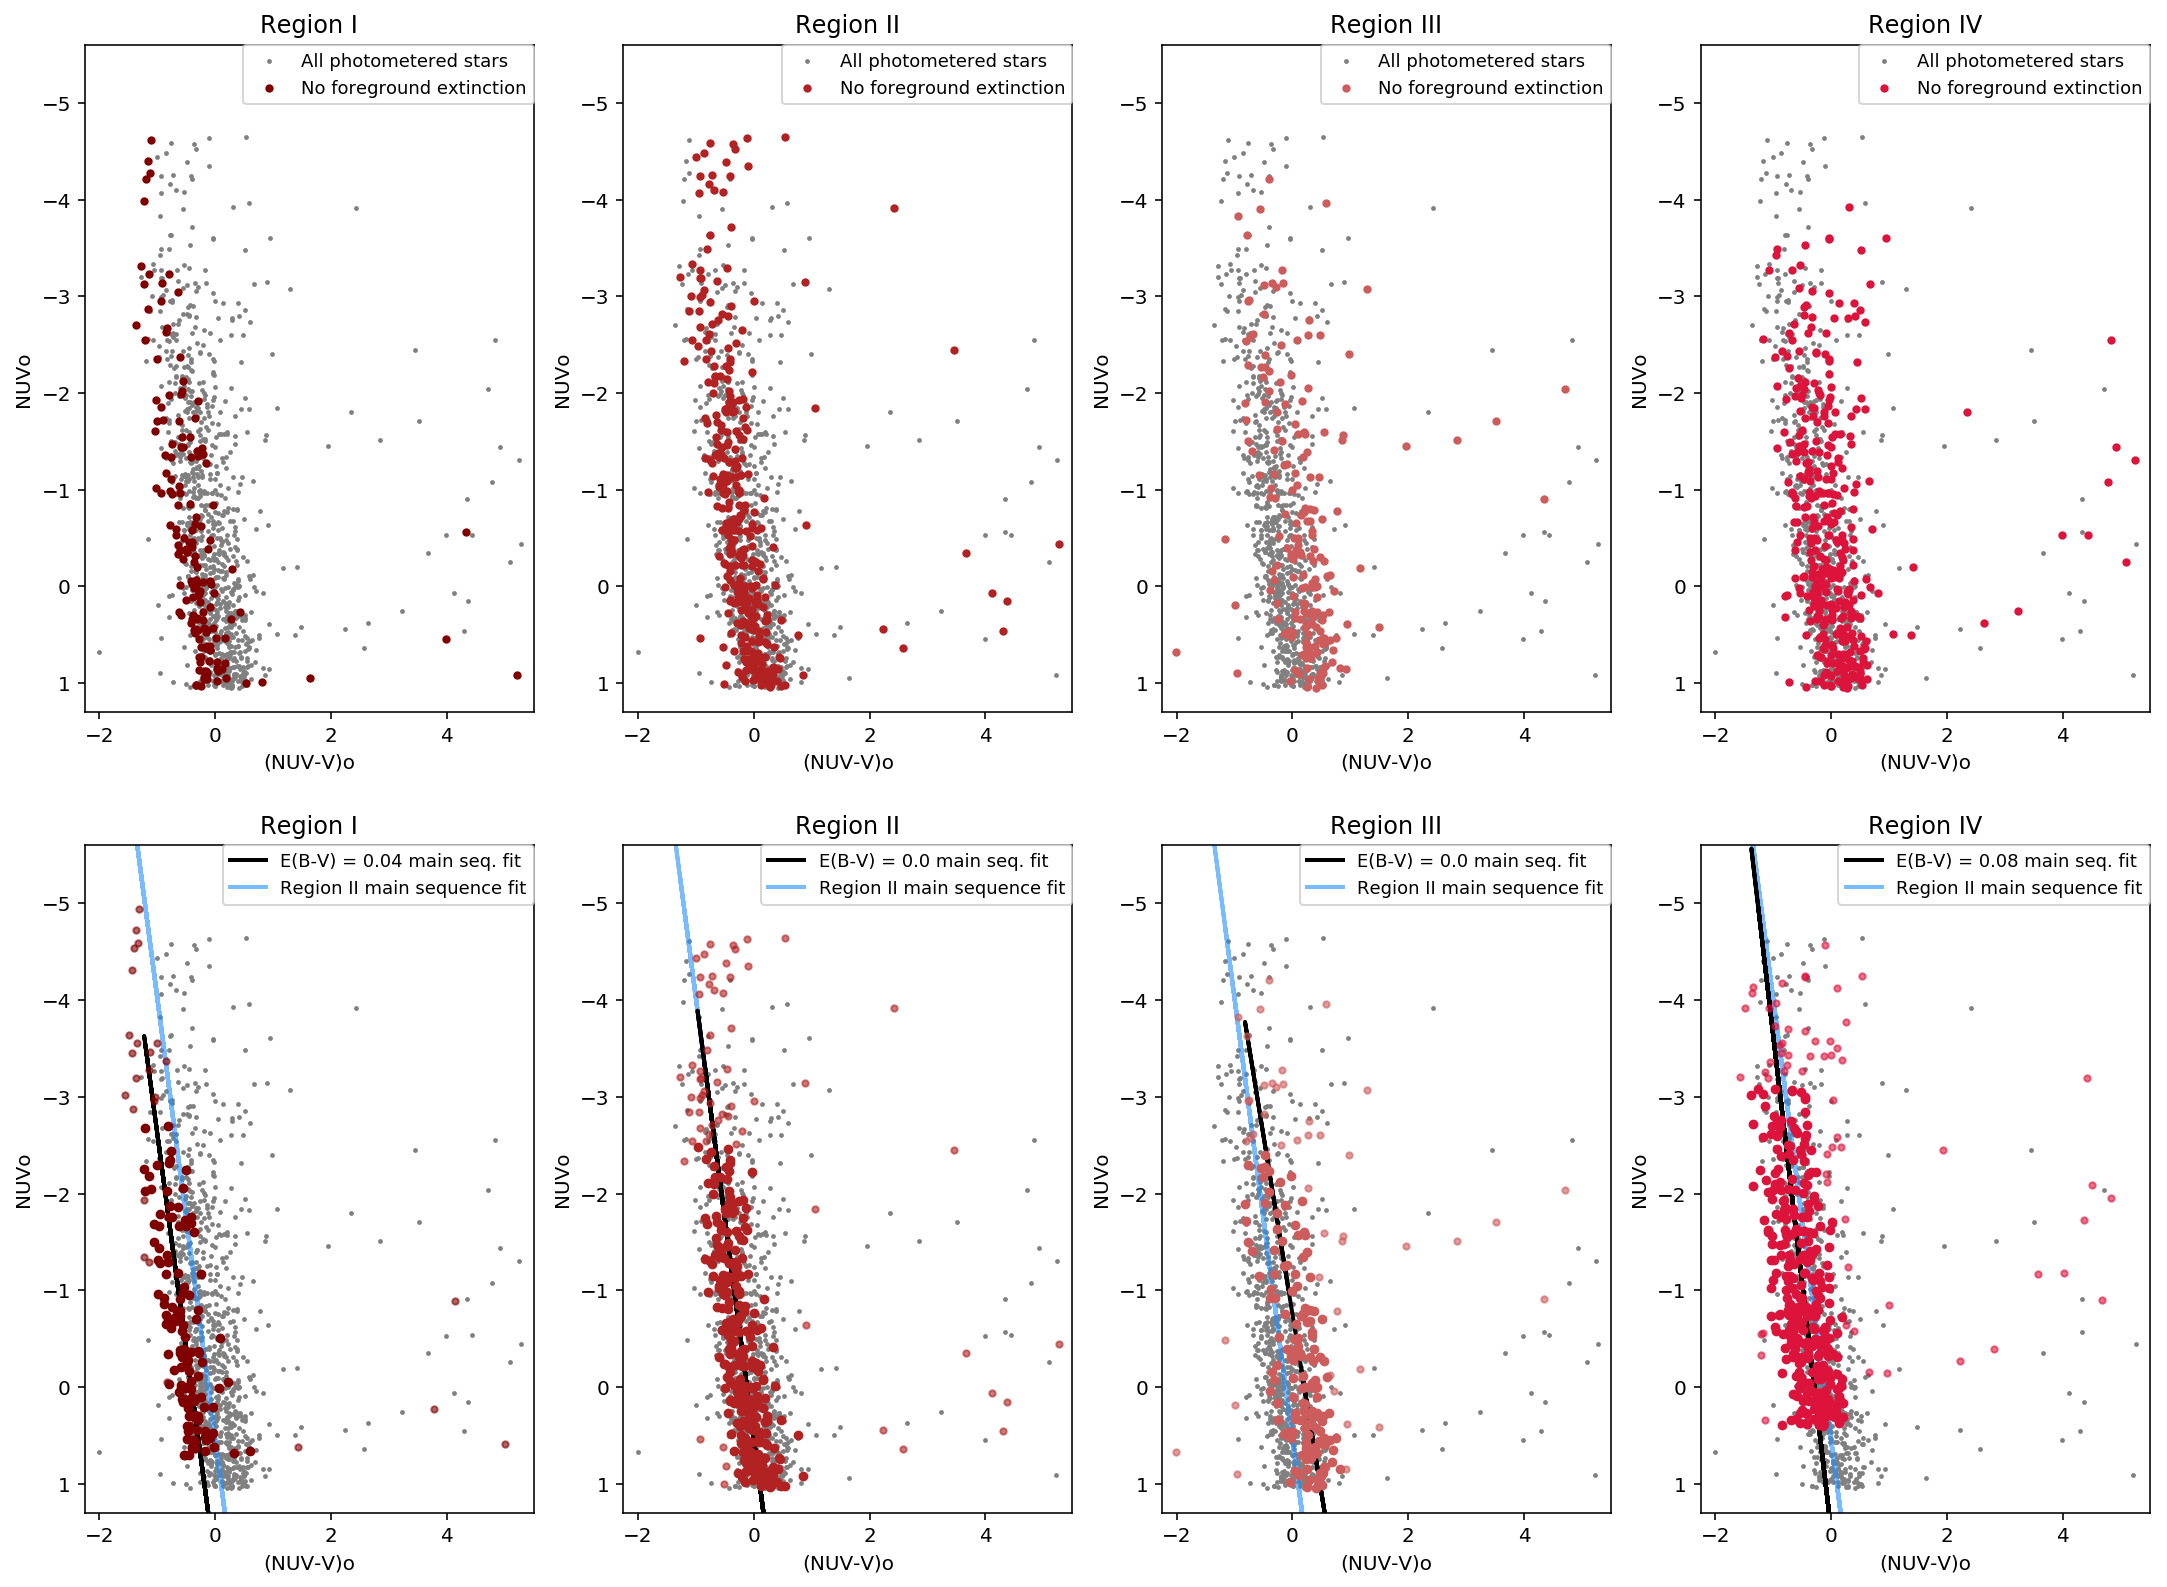

In [10]:
# No foreground extinction
plt.figure(figsize=(18.5, 13.5))
a, b = 2,4

for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+1)
    smc.plot_field(nuv_v, nuv, True)
    smc.plot_region('nuv', NUV_V[i], NUV[i], colors[i], labels[i], 'No foreground extinction', True)

# Foreground extinction
for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+5)
    smc.plot_field(NUV_V[(i+1) % 4], NUV[(i+1) % 4], False)
    smc.plot_field(NUV_V[(i+2) % 4], NUV[(i+2) % 4], False)
    smc.plot_field(NUV_V[(i+3) % 4], NUV[(i+3) % 4], False)
    
    extinction_correction('NUV', NUV_V[i], NUV[i], NUV_V_MAIN[i], NUV_MAIN[i], EB_V[i], \
                            spectral_EB_V[i], colors[i], labels[i], labels[i], \
                          0.5411565610047219, 4.563924287144373)

plt.savefig("images/Shell_Environment_Photometric_Comparison_NUV.jpg")
plt.show()

## Foreground extinction summary

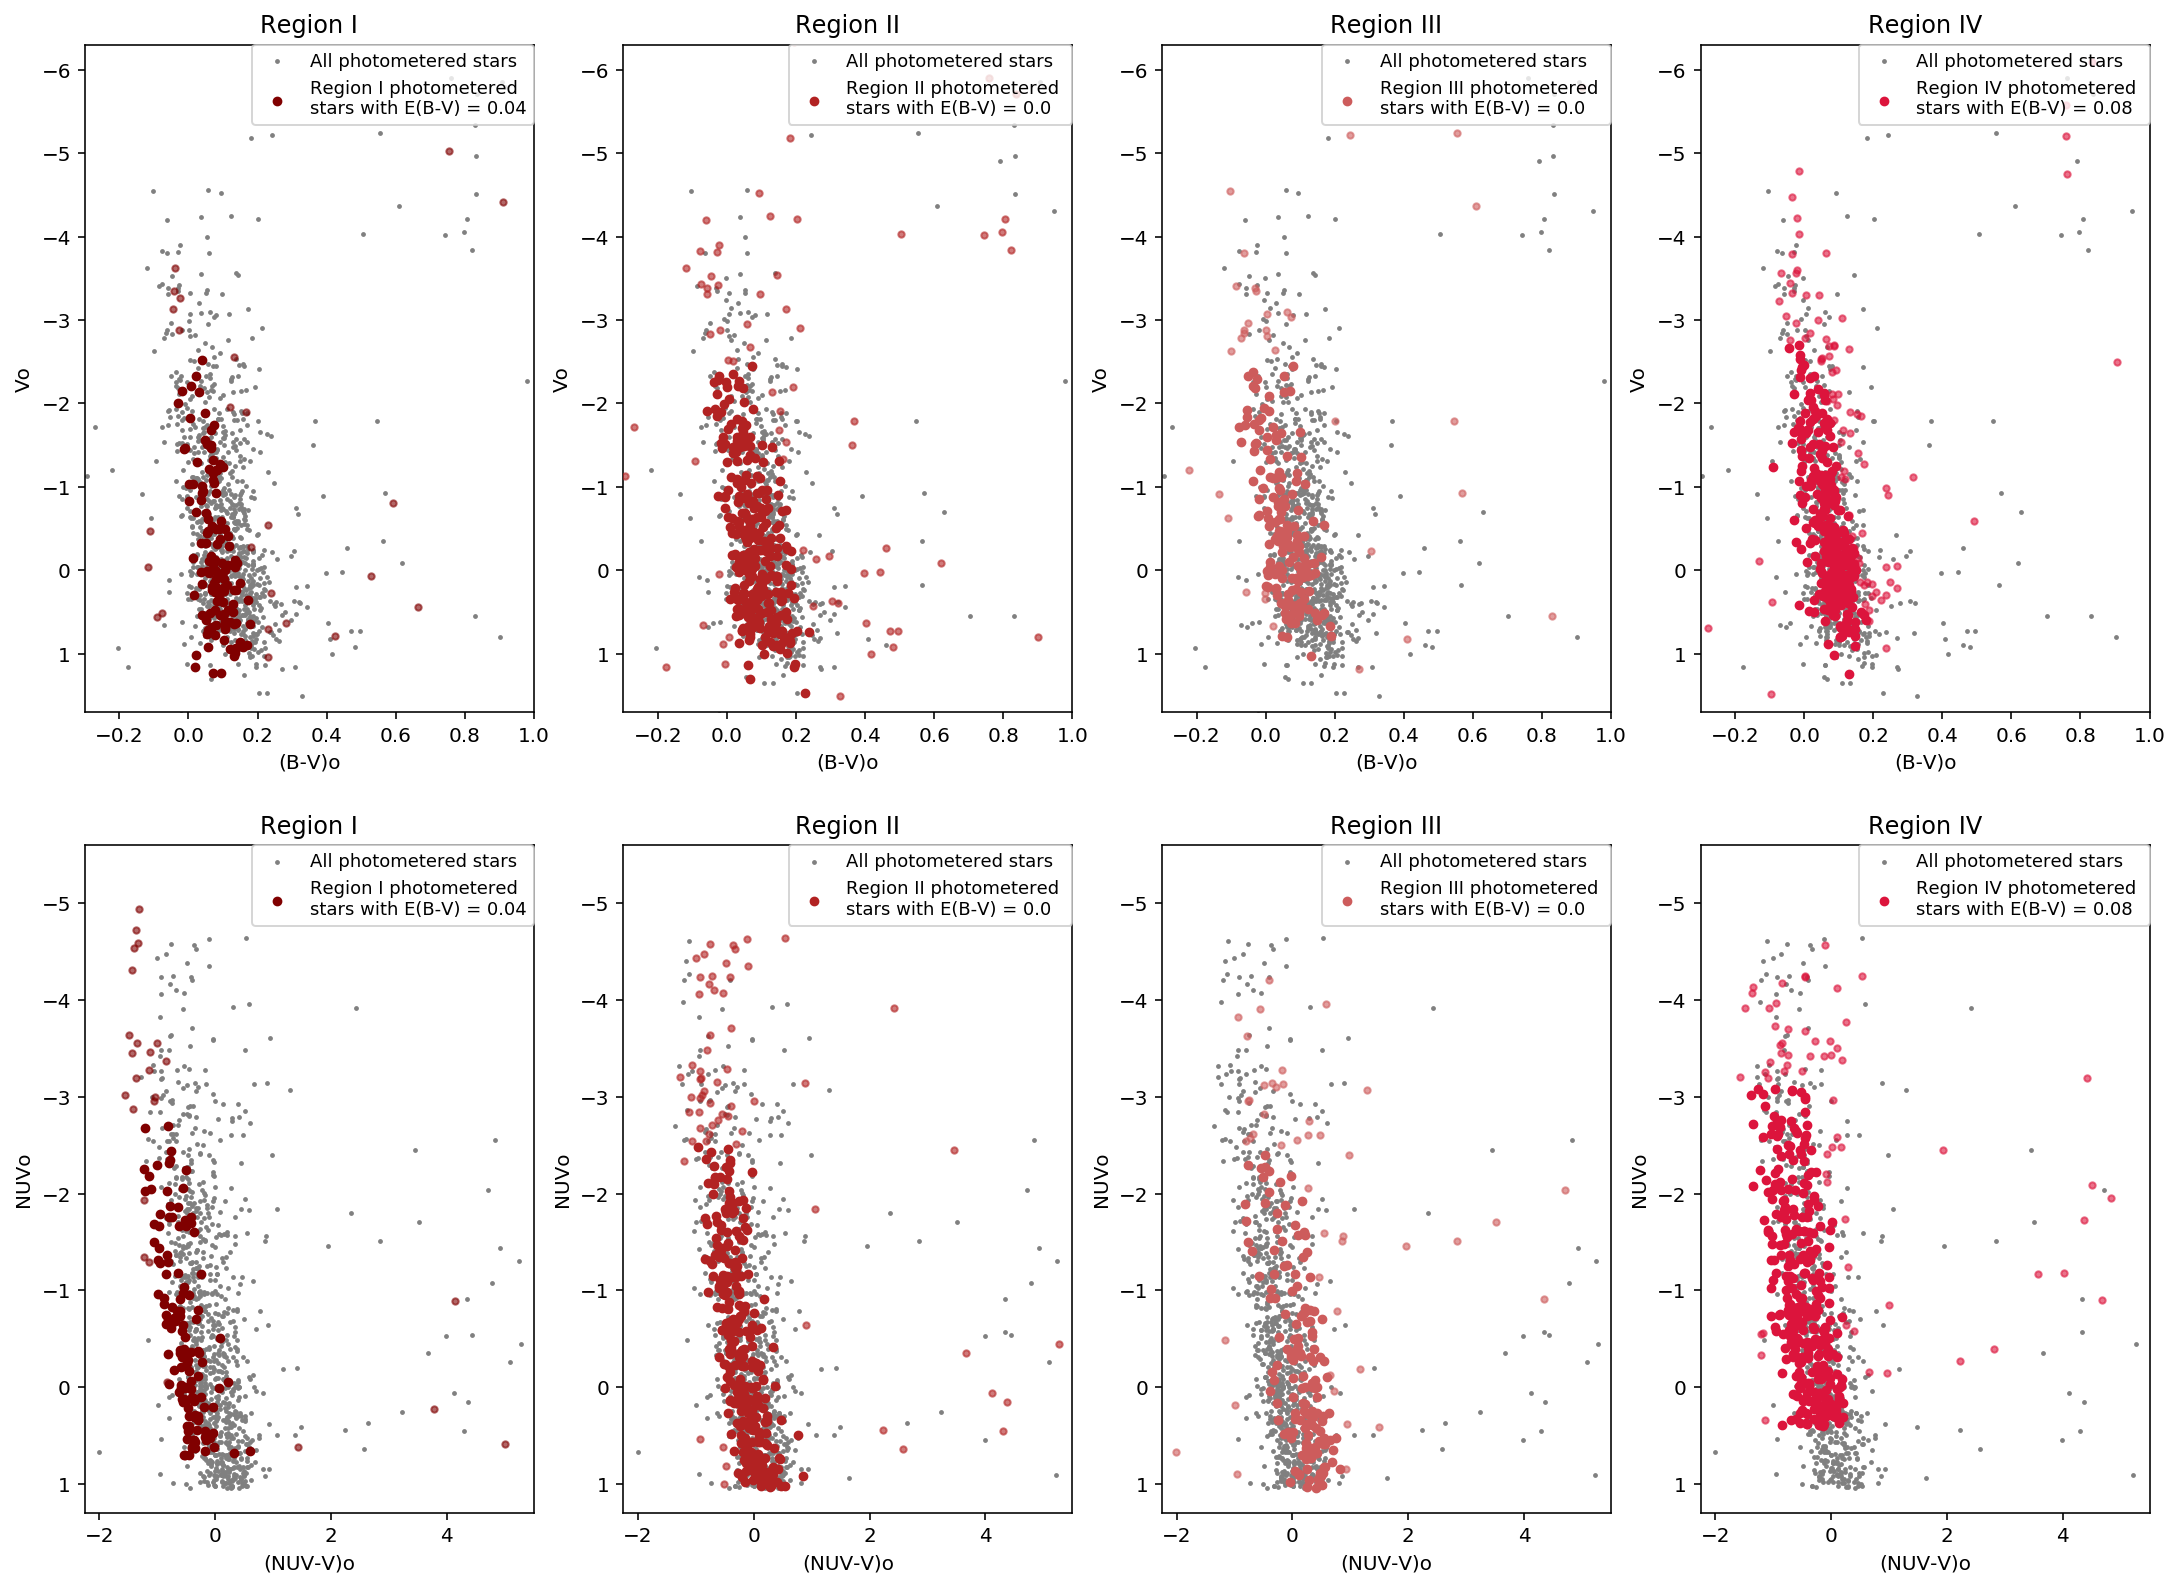

In [11]:
# Plot
plt.figure(figsize=(18.5, 13.5))
a,b = 2,4
    
# Vo vs. (B-V)o
for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+1)
    
    a_b = 3.85 * EB_V[i]
    a_v = 2.93 * EB_V[i]
    a_nuv = 8.08 * EB_V[i]
    
    smc.plot_field(B_V[(i+1) % 4], V[(i+1) % 4], False)
    smc.plot_field(B_V[(i+2) % 4], V[(i+2) % 4], False)
    smc.plot_field(B_V[(i+3) % 4], V[(i+3) % 4], True)
    
    plt.scatter(B_V[i] + a_b - a_v, V[i] + a_v, color=colors[i], s=10, marker="o", alpha=0.6, \
                zorder=3)
    plt.scatter(B_V_MAIN[i] + a_b - a_v, V_MAIN[i] + a_v, color=colors[i], s=15, marker="o", \
                zorder=4, label = labels[i]+' photometered \nstars with E(B-V) = '+str(abs(EB_V[i])))
    smc.plt_b(labels[i], True)
    
    # NUVo vs. (NUV-V)o
    plt.subplot(a,b,i+5)
    smc.plot_field(NUV_V[(i+1) % 4], NUV[(i+1) % 4], False)
    smc.plot_field(NUV_V[(i+2) % 4], NUV[(i+2) % 4], False)
    smc.plot_field(NUV_V[(i+3) % 4], NUV[(i+3) % 4], True)
    
    plt.scatter(NUV_V[i] + a_nuv - a_v, NUV[i] + a_nuv, color=colors[i], s=10, marker="o", alpha=0.6, \
                zorder=3)
    plt.scatter(NUV_V_MAIN[i] + a_nuv - a_v, NUV_MAIN[i] + a_nuv, color=colors[i], s=15, marker="o", \
                zorder=4, label = labels[i]+' photometered \nstars with E(B-V) = '+str(abs(EB_V[i])))
    smc.plt_nuv(labels[i], True)

plt.savefig("images/Shell_Environment_Photometric_Correction.jpg")
plt.show()

## Color-color foreground extinction application

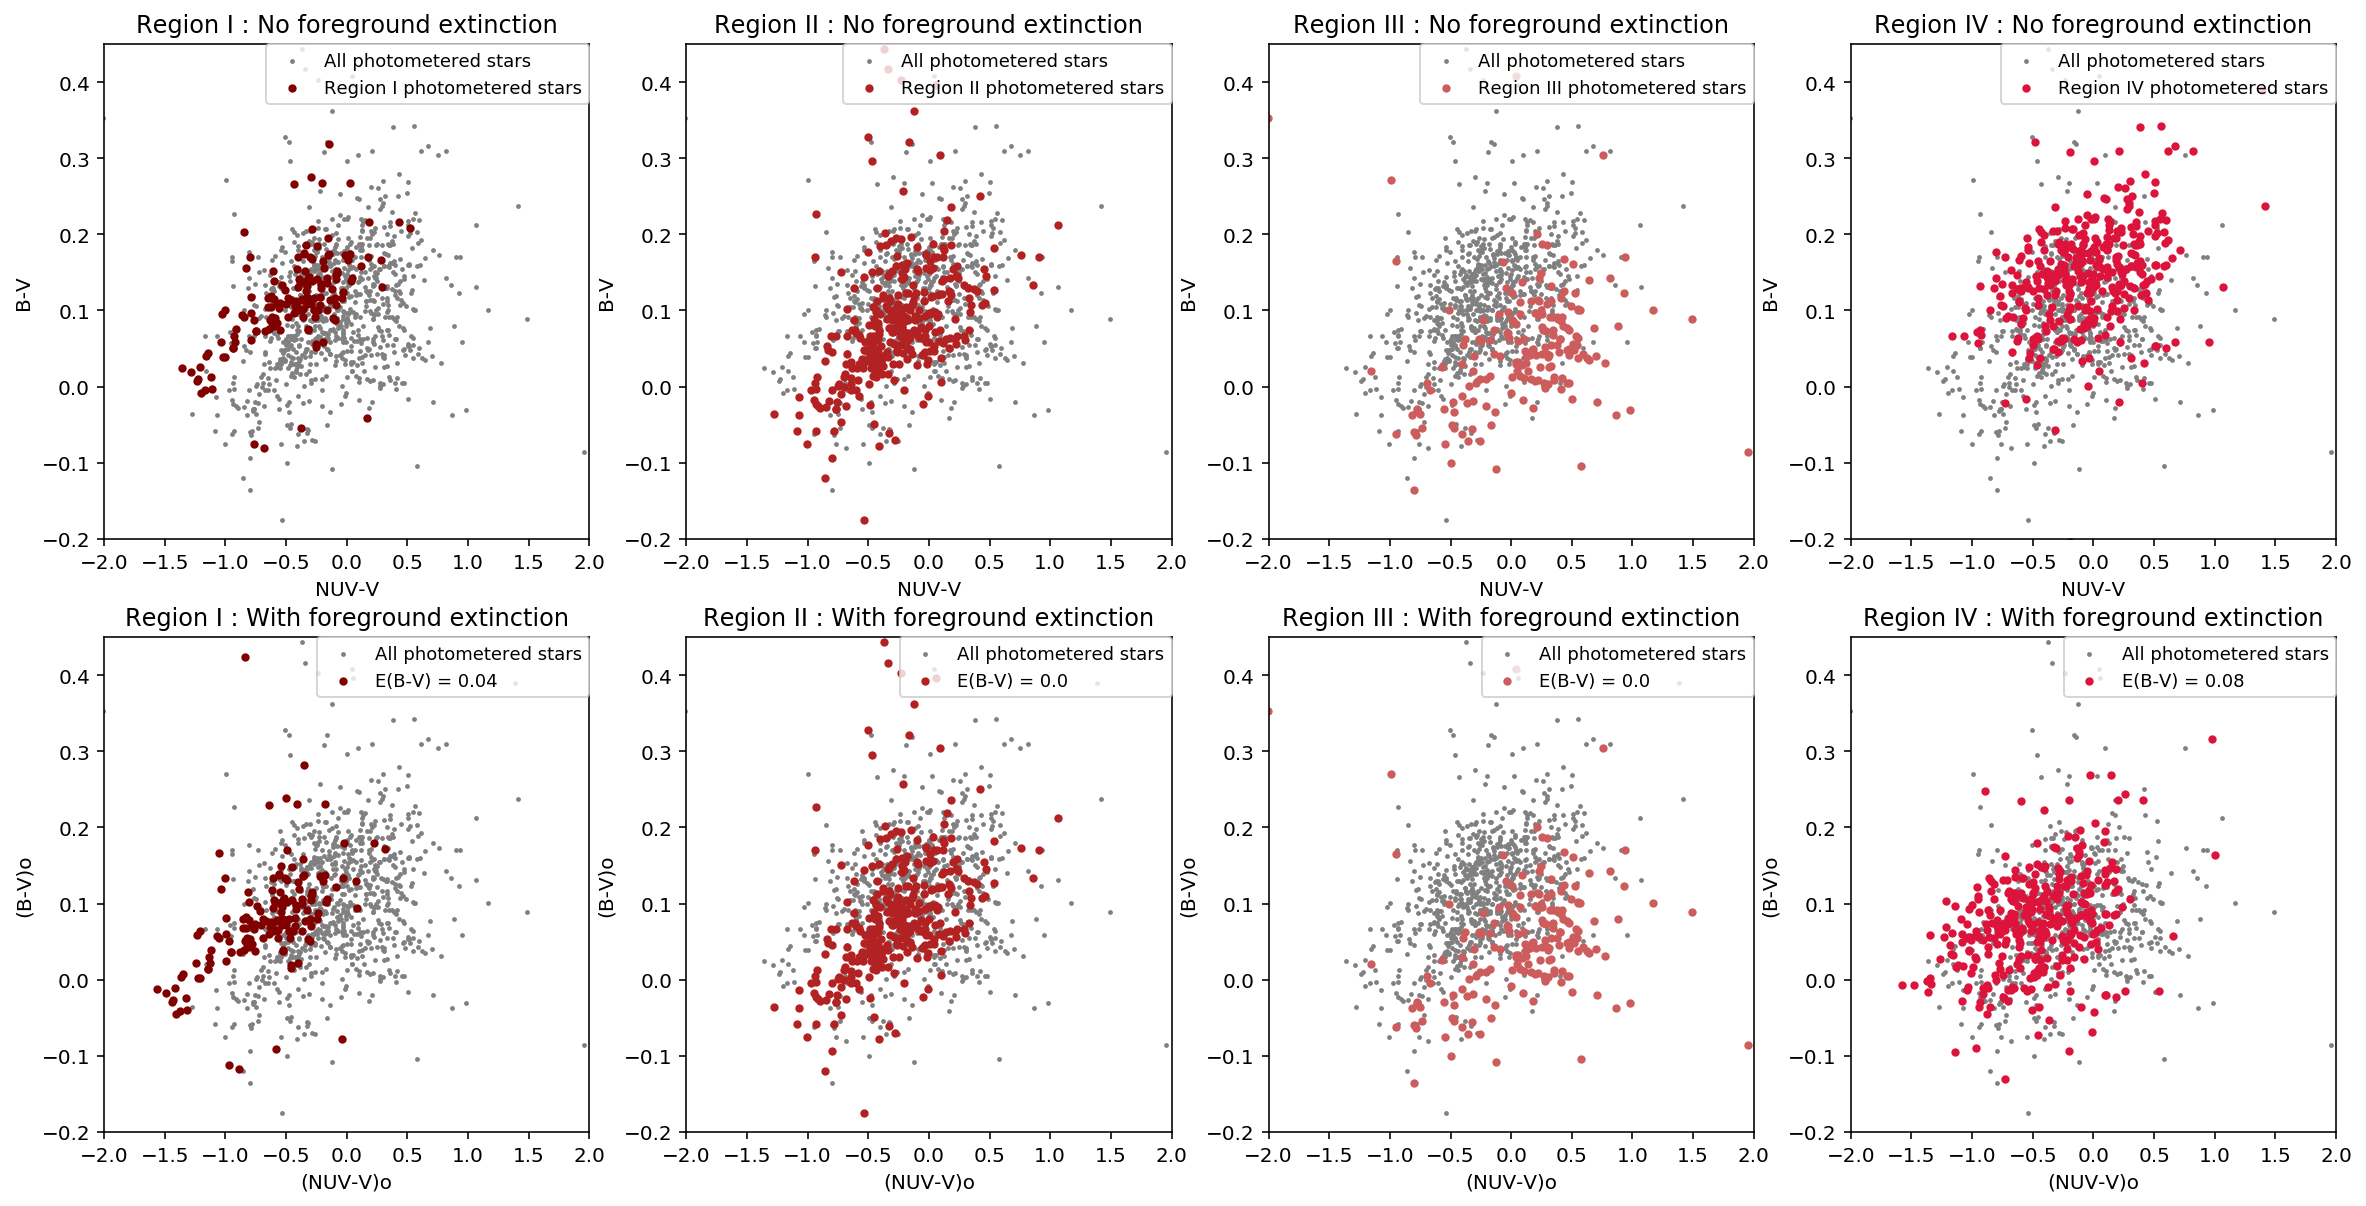

In [12]:
# Photometric Regions, Uncorrected
plt.figure(figsize=(20, 10))
a, b = 2,4

for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+1)
    
    a_b = 3.85 * EB_V[i]
    a_v = 2.93 * EB_V[i]
    a_nuv = 8.08 * EB_V[i]
    
    # Without foreground extinction
    plt.scatter(nuv_v, b_v, color='grey', label="All photometered stars", s=2, marker="o")
    plt.scatter(NUV_V[i], B_V[i], color=colors[i], label=labels[i]+' photometered stars', s=10, marker="o", alpha=1.0)
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':9})
    plt.title(labels[i]+' : No foreground extinction')
    plt.ylabel("B-V")
    plt.xlabel("NUV-V")
    plt.ylim(-0.2, 0.45)
    plt.xlim(-2, 2)

    # With foreground extinction
    plt.subplot(a,b,i+5)
    plt.scatter(NUV_V[(i+1) % 4], B_V[(i+1) % 4], color='grey', s=2, marker="o")
    plt.scatter(NUV_V[(i+2) % 4], B_V[(i+2) % 4], color='grey', s=2, marker="o")
    plt.scatter(NUV_V[(i+3) % 4], B_V[(i+3) % 4], color='grey', s=2, marker="o", label = 'All photometered stars')
    
    plt.scatter(NUV_V[i] + a_nuv - a_v, B_V[i] + a_b - a_v, color=colors[i], \
                label= 'E(B-V) = '+str(abs(EB_V[i])), s=10, marker="o", alpha=1.0)
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':9})
    
    plt.title(labels[i]+' : With foreground extinction')
    plt.ylabel("(B-V)o")
    plt.xlabel("(NUV-V)o")
    plt.ylim(-0.2, 0.45)
    plt.xlim(-2, 2)

    
plt.savefig("images/Shell_Environment_Color_Comparison.jpg")
plt.show()

## Color-color foreground extinction summary

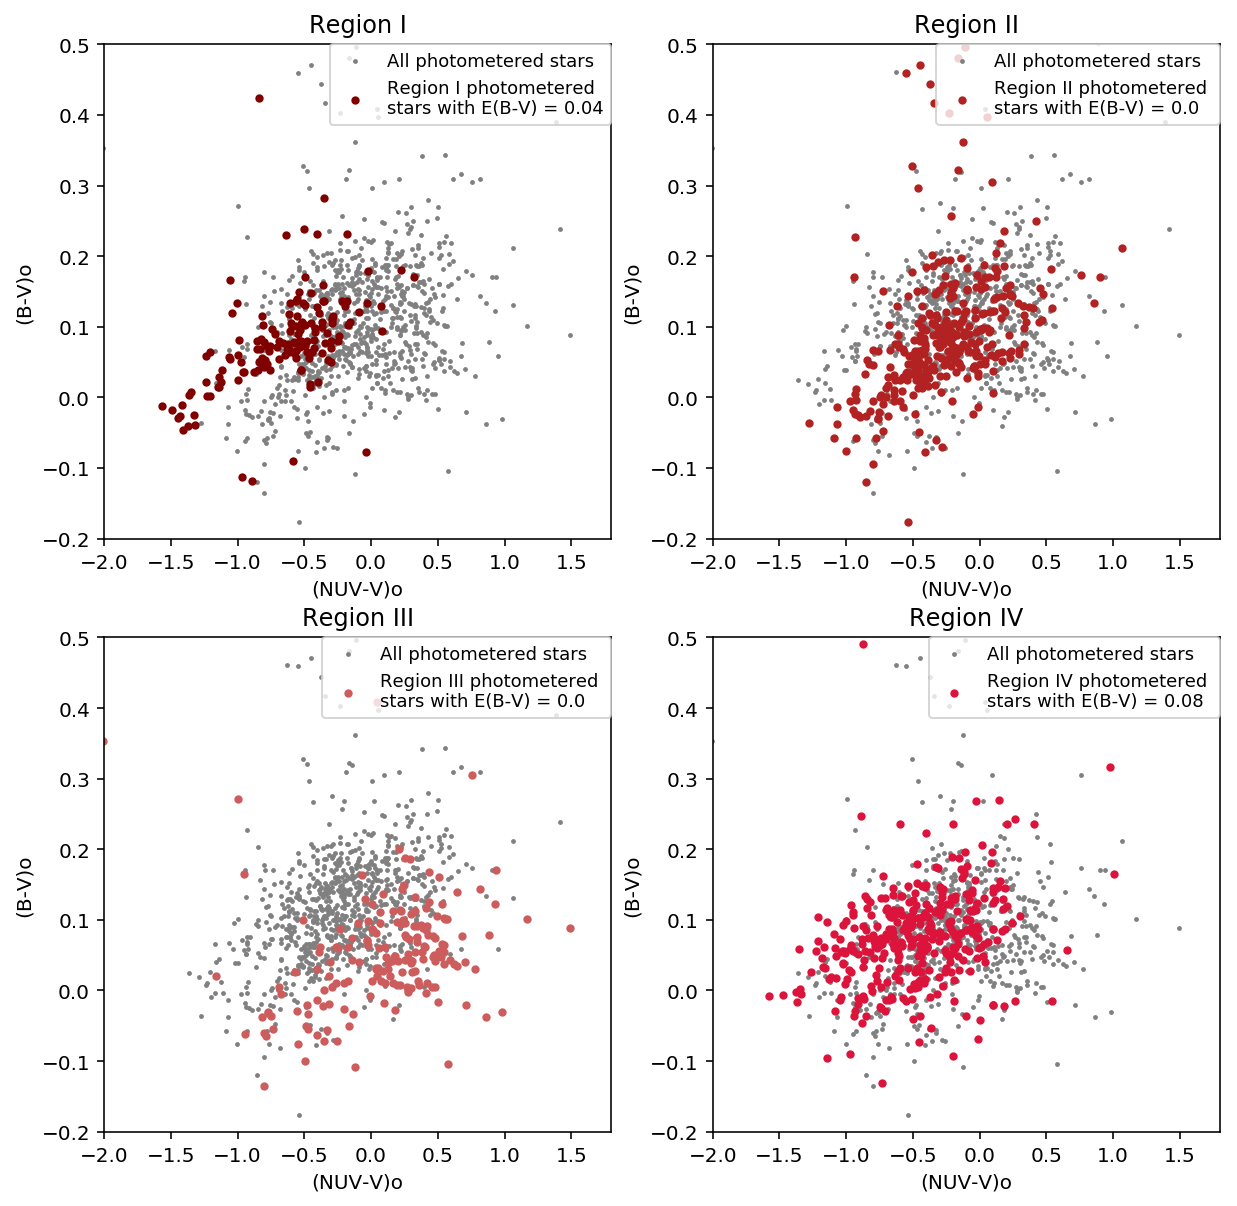

In [13]:
plt.figure(figsize=(10, 10))
a, b = 2,2

for i in [0, 1, 2, 3]:
    plt.subplot(a,b,i+1)
    
    a_b = 3.85 * EB_V[i]
    a_v = 2.93 * EB_V[i]
    a_nuv = 8.08 * EB_V[i]

    # With foreground extinction
    plt.scatter(NUV_V[(i+1) % 4], B_V[(i+1) % 4], color='grey', s=2, marker="o")
    plt.scatter(NUV_V[(i+2) % 4], B_V[(i+2) % 4], color='grey', s=2, marker="o")
    plt.scatter(NUV_V[(i+3) % 4], B_V[(i+3) % 4], color='grey', s=2, marker="o", \
                label = 'All photometered stars')
    
    plt.scatter(NUV_V[i] + a_nuv - a_v, B_V[i] + a_b - a_v, color=colors[i], \
                label = labels[i]+' photometered \nstars with E(B-V) = '+str(abs(EB_V[i])), s=10, marker="o", alpha=1.0)
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':9})
    
    plt.title(labels[i])
    plt.ylabel("(B-V)o")
    plt.xlabel("(NUV-V)o")
    plt.ylim(-0.2, 0.5)
    plt.xlim(-2, 1.8)

    
plt.savefig("images/Shell_Environment_Color_Comparison.jpg")
plt.show()

## Foreground corrected color-magnitude diagrams

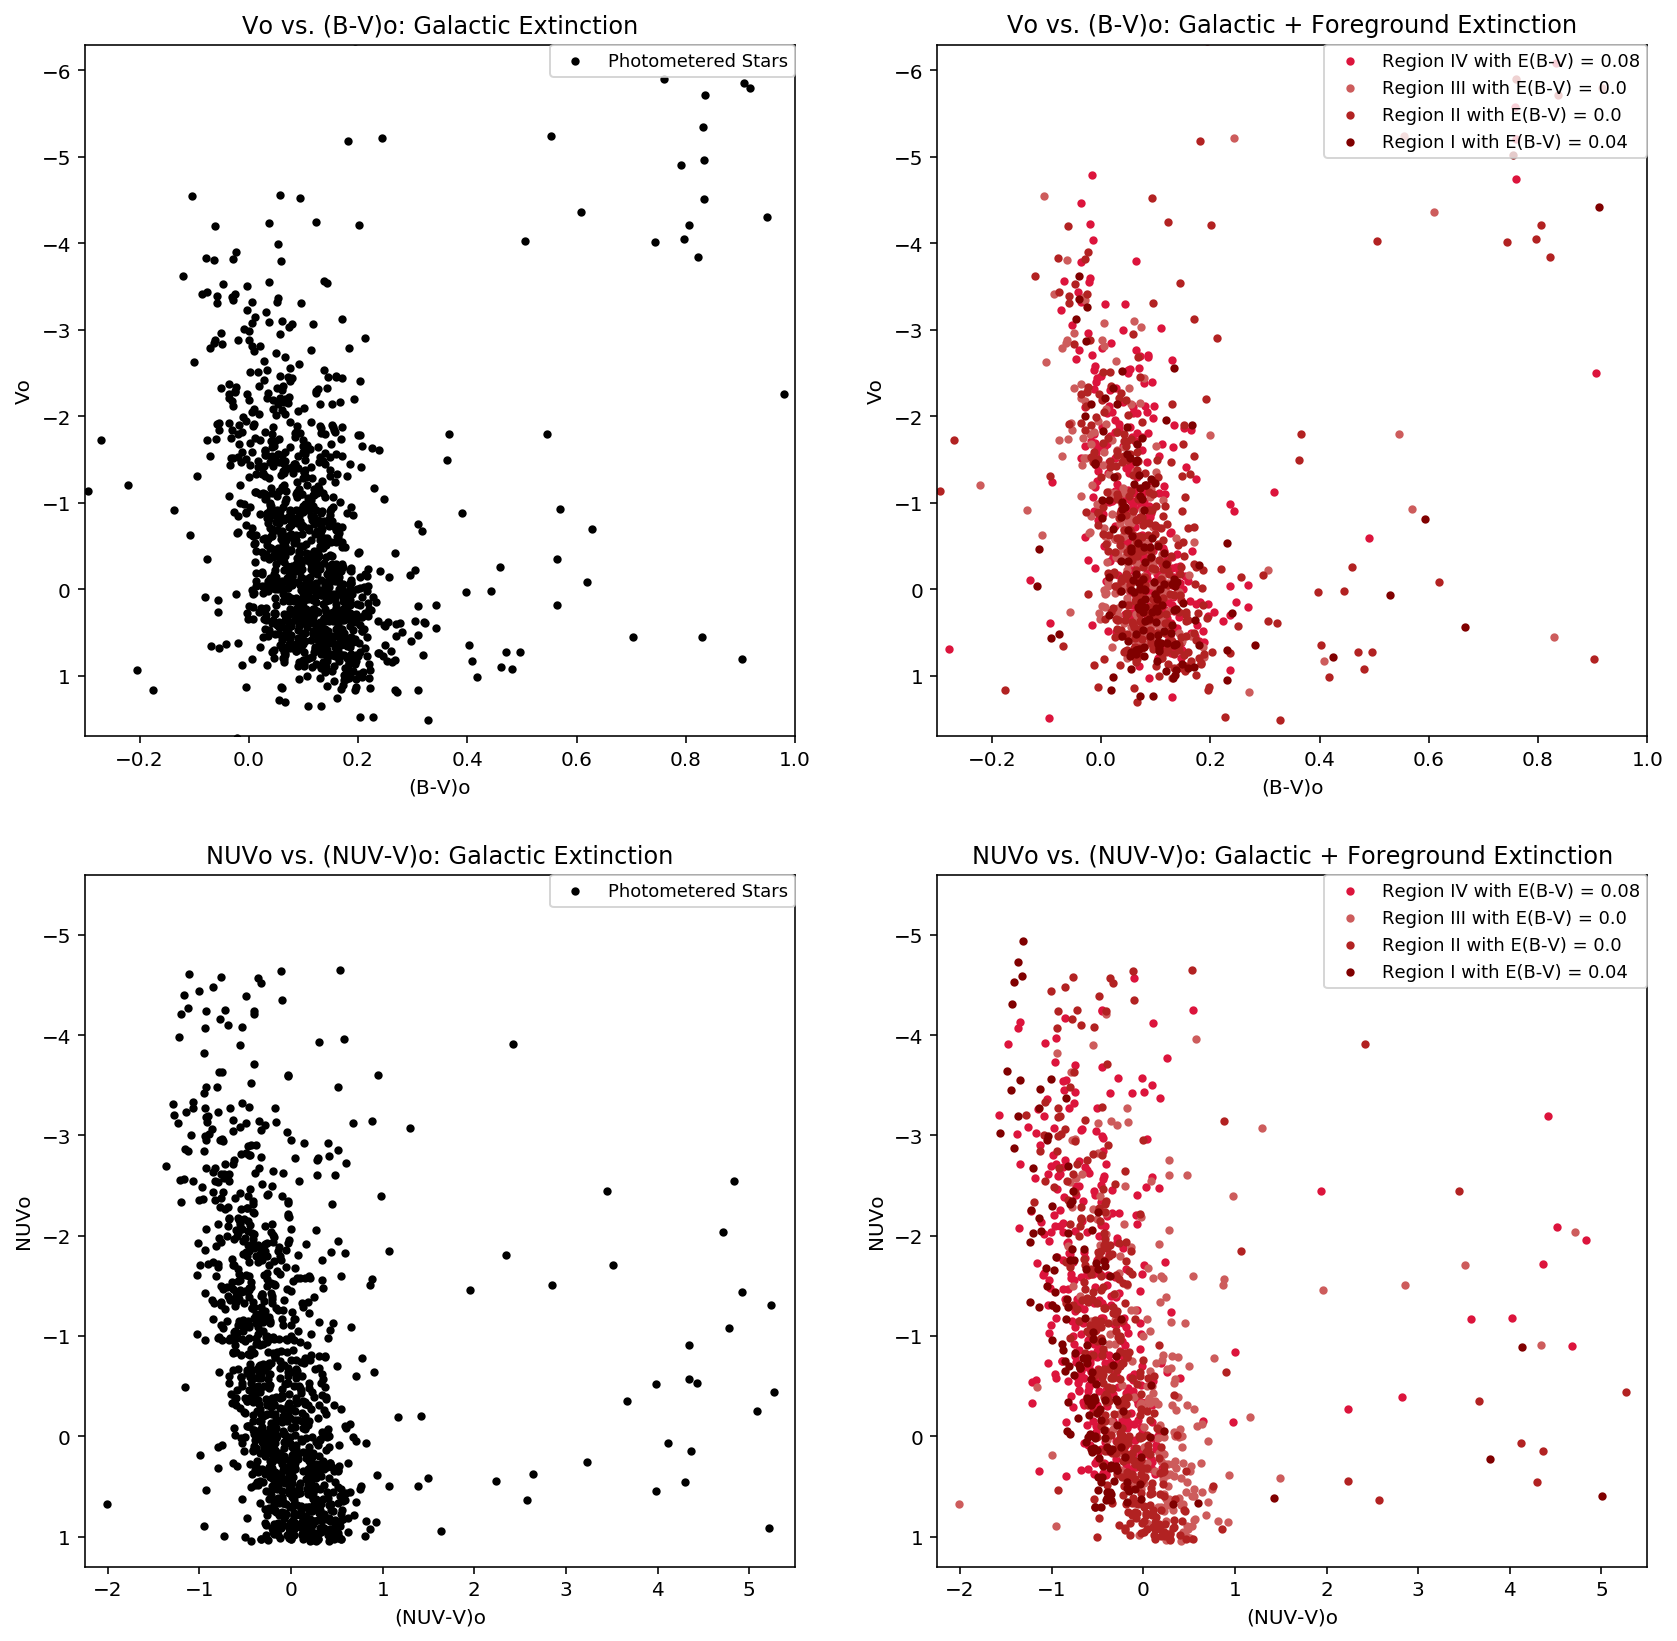

In [14]:
# Plot

plt.figure(figsize=(14, 14))
a,b = 2,2

plt.subplot(a,b,1)
smc.plot_region('b', b_v, v, 'k', 'Vo vs. (B-V)o: Galactic Extinction', 'Photometered Stars', True)


plt.subplot(a,b,2)
for i in [3, 2, 1, 0]:
    smc.plot_region('b', B_V[i] + A_B[i] - A_V[i], V[i] + A_V[i], colors[i], \
                 'Vo vs. (B-V)o: Galactic + Foreground Extinction', \
             labels[i]+' with E(B-V) = '+str(np.abs(EB_V[i])), True)

plt.subplot(a,b,3)
smc.plot_region('nuv', nuv_v, nuv, 'k', 'NUVo vs. (NUV-V)o: Galactic Extinction', 'Photometered Stars', True)

plt.subplot(a,b,4)
for i in [3, 2, 1, 0]:
    smc.plot_region('nuv', NUV_V[i] + A_NUV[i] - A_V[i], NUV[i] + A_NUV[i], colors[i], \
                 'NUVo vs. (NUV-V)o: Galactic + Foreground Extinction', \
             labels[i]+' with E(B-V) = '+str(np.abs(EB_V[i])), True)

plt.savefig("images/Foreground_Corrected_CMDs.jpg")
plt.show()

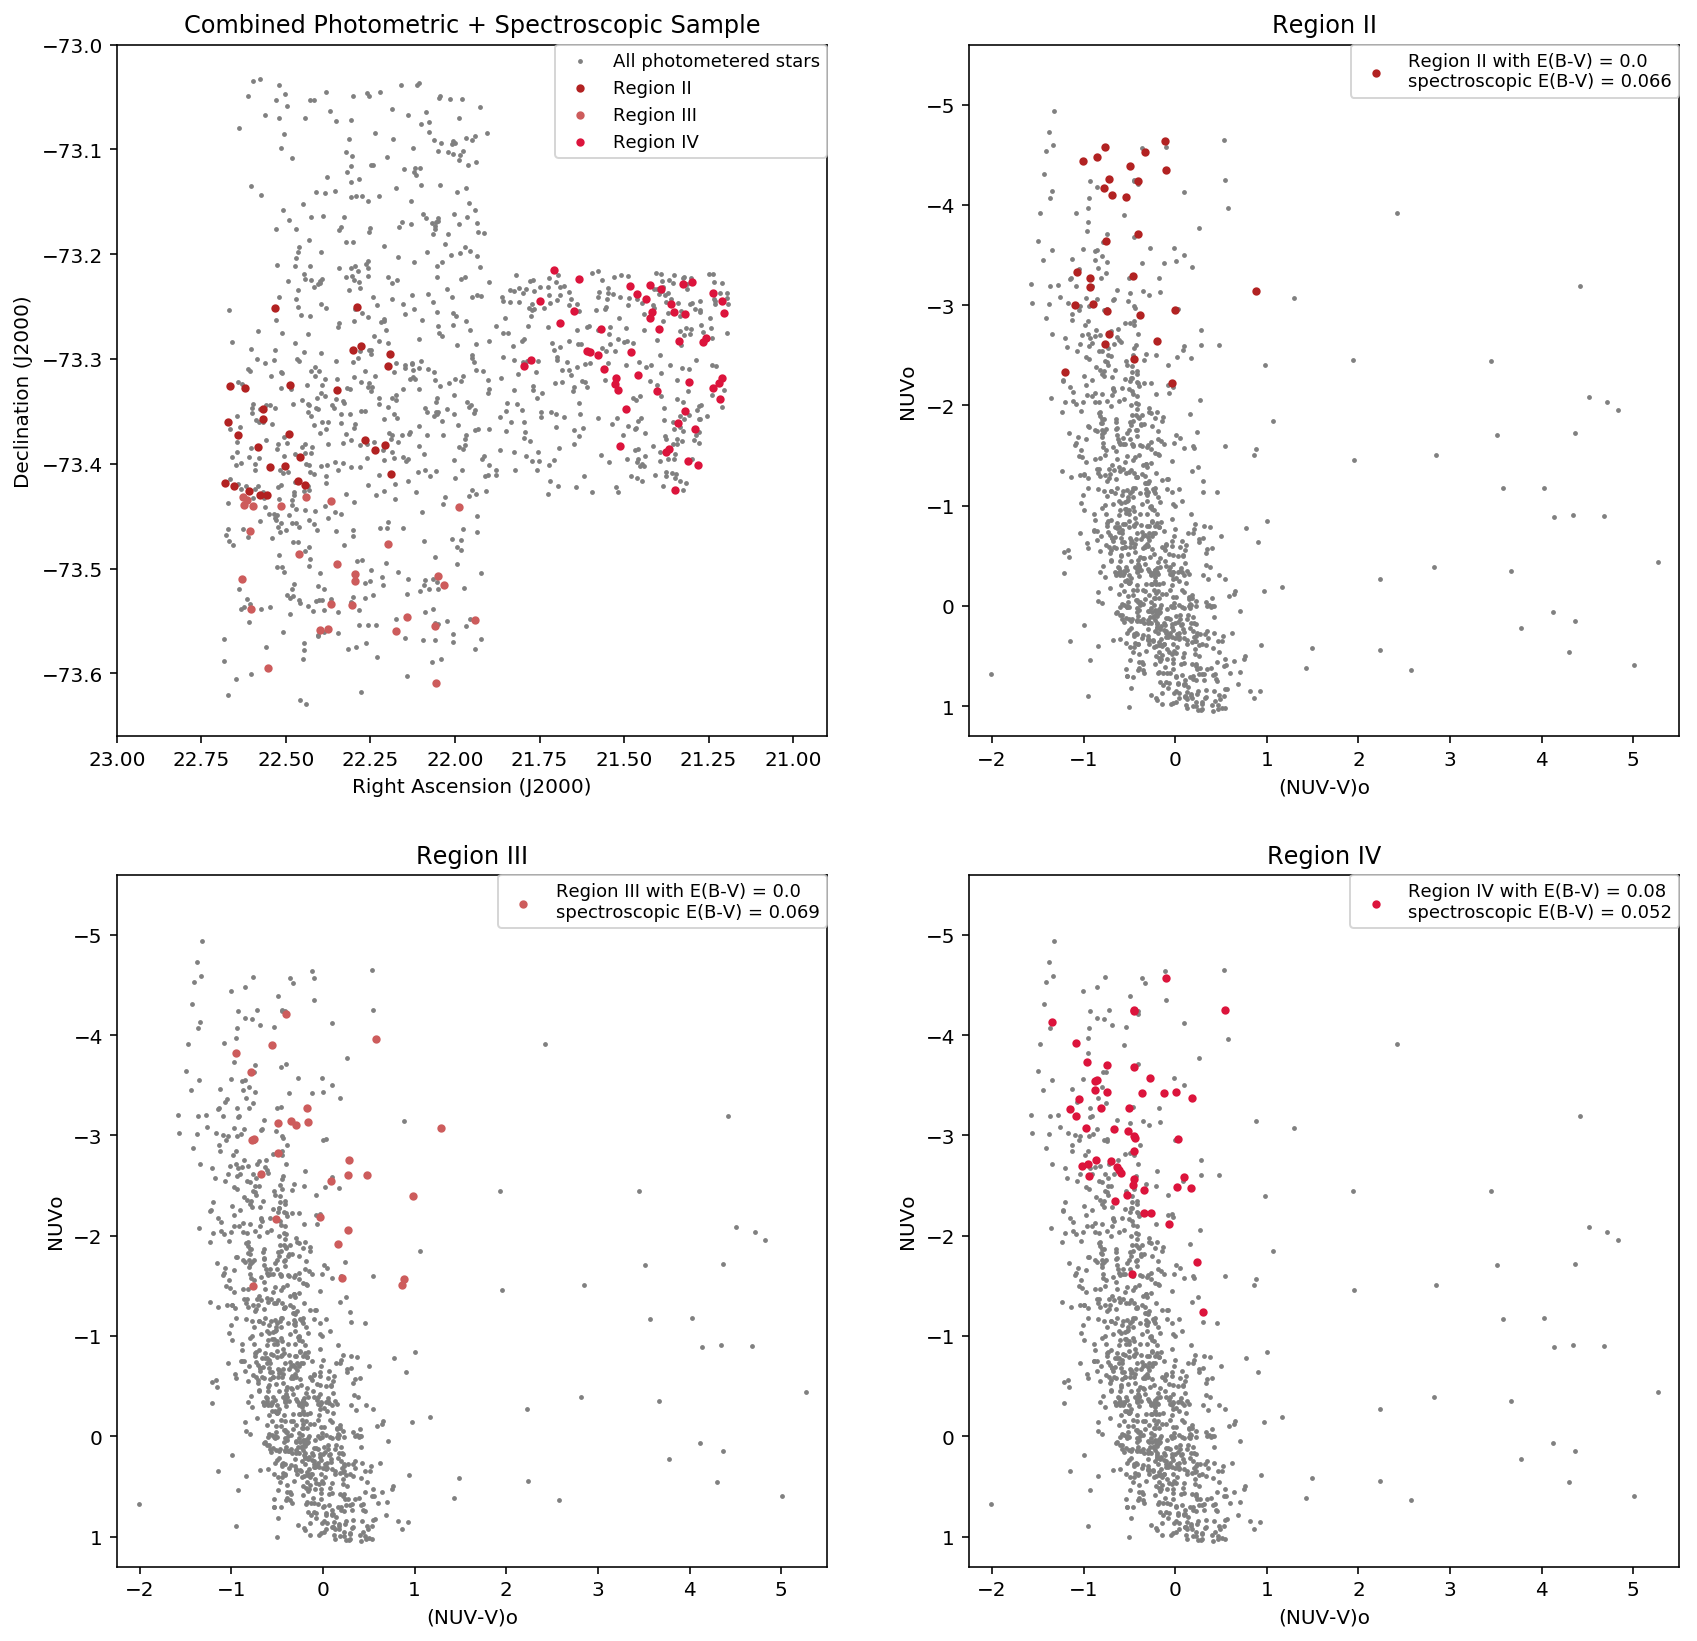

In [15]:
# Compare to spectra for the four regions (remake that great plot!)

s_RA = [s_I.ra, s_II.ra, s_III.ra, s_IV.ra]
s_DEC = [s_I.dec, s_II.dec, s_III.dec, s_IV.dec]

s_NUV_V = [s_I.nuv_v, s_II.nuv_v, s_III.nuv_v, s_IV.nuv_v]
s_NUV = [s_I.nuv, s_II.nuv, s_III.nuv, s_IV.nuv]

plt.figure(figsize=(14, 14))
a,b = 2,2

plt.subplot(a,b,1)
smc.plot_field(ra, dec, True)
for i in [1, 2, 3]:
    smc.plot_region('spatial', s_RA[i], s_DEC[i], colors[i], \
                "Combined Photometric + Spectroscopic Sample", labels[i], True)

for i in [1, 2, 3]:
    plt.subplot(a,b,i+1)
    
    for j in [3, 2, 1, 0]:
        smc.plot_field(NUV_V[j] + A_NUV[j] - A_V[j], NUV[j] + A_NUV[j], False)
        smc.plt_nuv(False, False)
        
    smc.plot_region('nuv', s_NUV_V[i] + A_NUV[i] - A_V[i], s_NUV[i] + A_NUV[i], \
                 colors[i], labels[i], labels[i]+' with E(B-V) = '+str(np.abs(EB_V[i]))+\
            '\nspectroscopic E(B-V) = '+str(np.round(spectral_EB_V[i], 3)), True)
    
plt.savefig("images/Shell_Environment_Spectroscopic_Comparison.jpg")
plt.show()

## Save the resulting photometric sample

In [16]:
id_number = np.hstack((I.id_number, II.id_number, III.id_number, IV.id_number))

ra = np.hstack((I.ra, II.ra, III.ra, IV.ra))
dec = np.hstack((I.dec, II.dec, III.dec, IV.dec))

nuv_v = np.hstack((I.nuv_v + A_NUV[0] - A_V[0], II.nuv_v + A_NUV[1] - A_V[1], III.nuv_v + A_NUV[2] - A_V[2], IV.nuv_v + A_NUV[3] - A_V[3]))
nuv = np.hstack((I.nuv + A_NUV[0], II.nuv + A_NUV[1], III.nuv + A_NUV[2], IV.nuv + A_NUV[3]))

b_v = np.hstack((I.b_v + EB_V[0], II.b_v + EB_V[1], III.b_v + EB_V[2], IV.b_v + EB_V[3]))
v = np.hstack((I.v + A_V[0], II.v + A_V[1], III.v + A_V[2], IV.v + A_V[3]))

foreground_corrected_photometry = np.column_stack((id_number, ra, dec, np.round(nuv_v, 5), \
                                                   np.round(nuv, 5), np.round(b_v, 5), np.round(v, 5)))

np.savetxt('../data/foreground_corrected_photometry', foreground_corrected_photometry, \
           delimiter=" ", fmt="%s", header = 'id ra dec nuv_v nuv b_v v')

# np.savetxt('../data/foreground_corrected_photometry_with_high_proper_motions', foreground_corrected_photometry, \
#            delimiter=" ", fmt="%s", header = 'id ra dec nuv_v nuv b_v v')